# Install Darts

In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 

# Load Data

In [2]:
from darts import TimeSeries
import matplotlib.pyplot as plt

In [3]:
import pandas as pd


def load_csv_day_ahead_prices(year):
  region = 3

  df = pd.read_csv(f'dap-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['MTU (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['MTU (CET/CEST)', f'BZN|SE{region}', 'Currency'],
    inplace=True
  )

  return df

def day_ahead_prices(start=2015, end=2023):
  region = 3

  df = pd.concat([load_csv_day_ahead_prices(year) for year in range(start, end + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df


def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Actual Total Load [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}': 'Day-ahead Total Load Forecast [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df


def load_smhi(filename): # start = 2015, end = 2023
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )
  df.ffill()
  df = df[~df.index.duplicated(keep='first')]
  return df

## All data for Day-ahead Prices

<Axes: xlabel='MTU (CET/CEST)'>

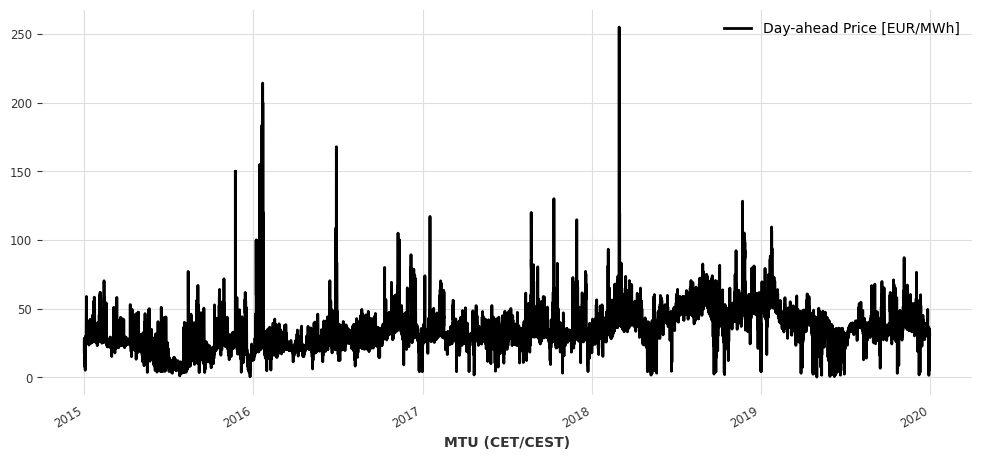

In [21]:
end_year = 2019

df = day_ahead_prices(start=2015, end=end_year)
series = TimeSeries.from_dataframe(df)

plt.figure(figsize=(12,5))
series.plot()

## Zooming in on a month

(0.0, 100.0)

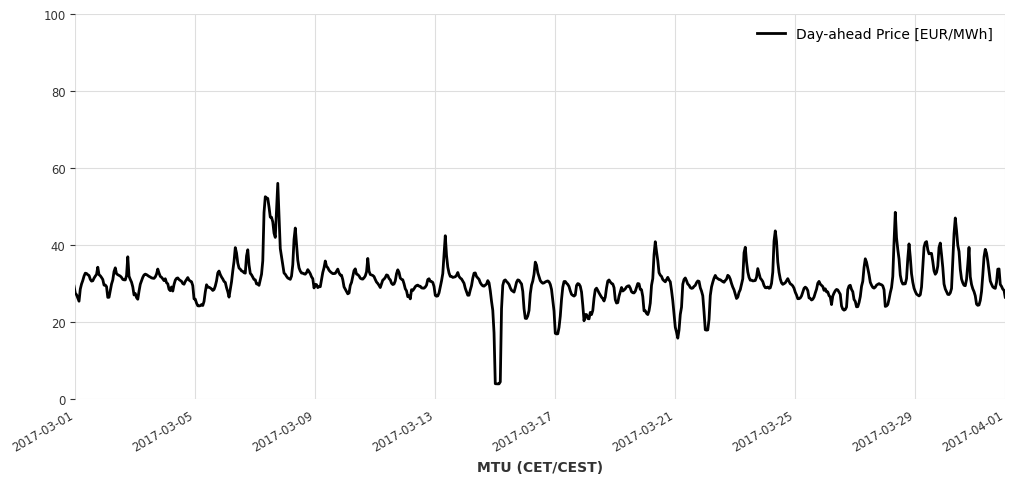

In [22]:
plt.figure(figsize=(12, 5))
series.plot()
plt.xlim(
  left=series.start_time() + pd.DateOffset(years=2, months=2),
  right=series.start_time() + pd.DateOffset(years=2, months=3)
)
plt.ylim(0, 100)

# Data Processing
A mirror-logarithmic transform has been used instead of a normal logarithm to account for the infrequent negative prices.

In [7]:
import numpy as np

class MLogScaler:
  def __init__(self, c = 1 / 3):
    self.c = c

  def fit(self, X):
    return self

  def transform(self, X):
    return np.sign(X) * (np.log(1 / self.c + np.abs(X)) + np.log(self.c))

  def inverse_transform(self, X):
    return np.sign(X) * (np.exp(np.abs(X) - np.log(self.c)) - 1 / self.c)

<Axes: xlabel='MTU (CET/CEST)'>

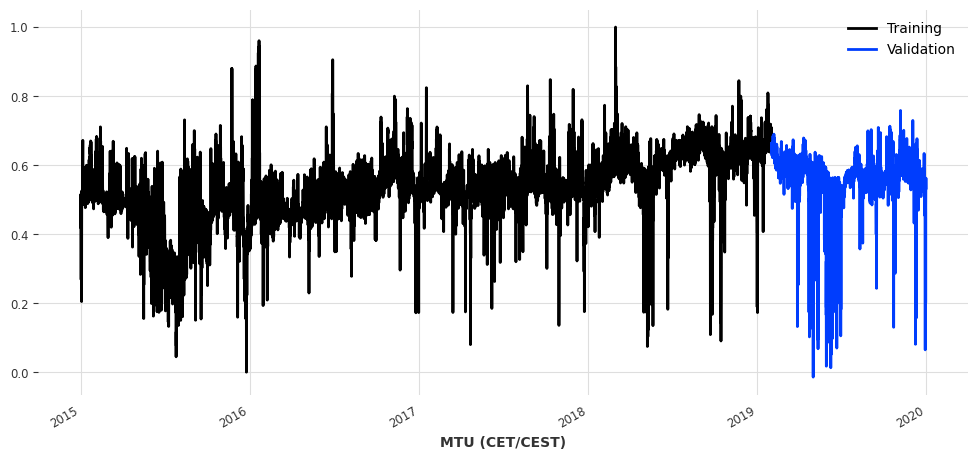

In [24]:
from darts.dataprocessing.transformers import Scaler

cutoff = pd.Timestamp(f'{end_year}-02-01')
train, val = series.split_before(cutoff)

mlog = Scaler(scaler=MLogScaler())
train_mlog = mlog.fit_transform(train)
val_mlog = mlog.transform(val)
series_mlog = mlog.transform(series)

compress = Scaler()
train_transformed = compress.fit_transform(train_mlog)
val_transformed = compress.transform(val_mlog)
series_transformed = compress.transform(series_mlog)

plt.figure(figsize=(12, 5))
train_transformed.plot(label='Training')
val_transformed.plot(label='Validation')

# Covariates

Other ideas:
- XGBoost
- MLP (Multi Layer Perceptor), tänk klassisk NN

# Predicted Load Covariate
The predicted load series has a lot of covariates essentially already "built in" to it.

<Axes: xlabel='Time (CET/CEST)'>

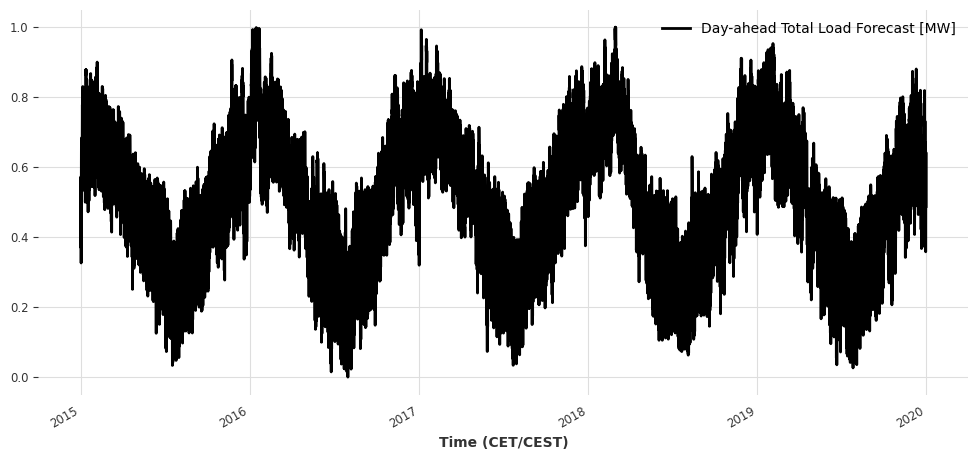

In [25]:
predicted_load_series = TimeSeries.from_dataframe(total_load_forecast(start=2015, end=end_year))

predicted_load_series = Scaler().fit_transform(predicted_load_series.map(lambda ts, x: np.log(x)))

plt.figure(figsize=(12, 5))
predicted_load_series.plot()

# DateTime Covariates

(16430.0, 16477.0)

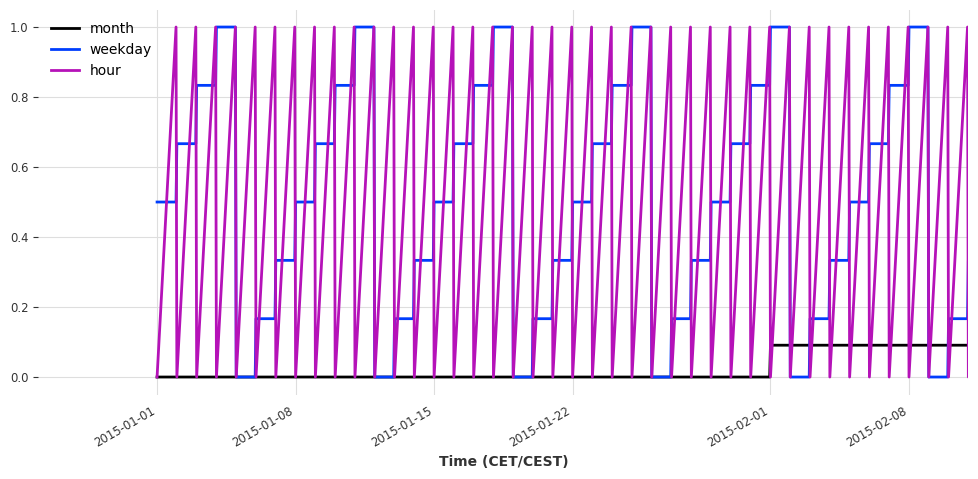

In [26]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

month_series = datetime_attribute_timeseries(
  predicted_load_series,
  attribute="month"
)
month_series = Scaler().fit_transform(month_series)

weekday_series = datetime_attribute_timeseries(
  month_series,
  attribute="weekday"
)
weekday_series = Scaler().fit_transform(weekday_series)

hour_series = datetime_attribute_timeseries(
  weekday_series,
  attribute="hour"
)
hour_series = Scaler().fit_transform(hour_series)

datetime_series = month_series.stack(weekday_series).stack(hour_series)

plt.figure(figsize=(12, 5))
datetime_series.plot()
plt.xlim(
  left=datetime_series.start_time() - pd.DateOffset(days=6),
  right=datetime_series.start_time() + pd.DateOffset(months=1, days=10)
)

# Weather Conditions
- Temperature, measured from Bromma Airport (BMA)
- Wind speed, measured from Bromma Airport (BMA)
- Solar radiation, measured from Stockholm Sol

(16436.0, 16495.0)

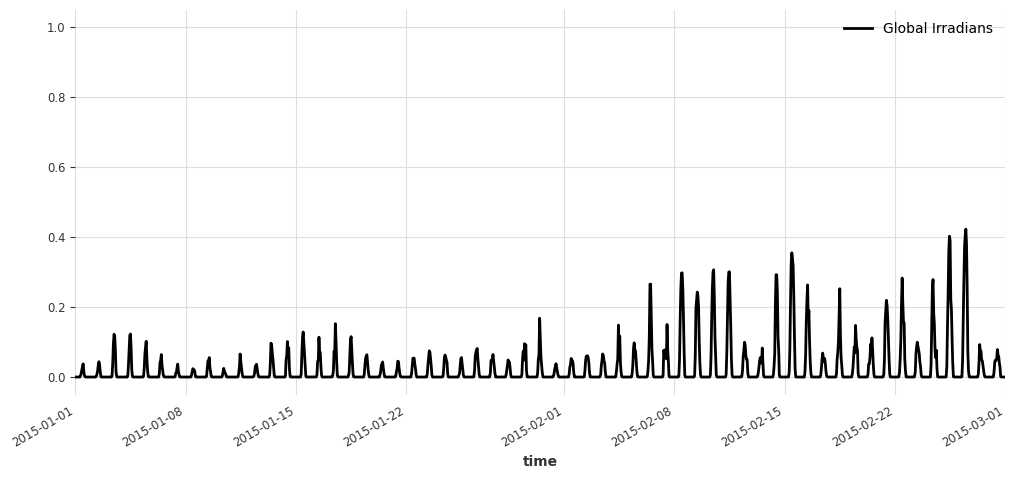

In [27]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv')
solar_df.ffill(inplace=True)

solar_series = TimeSeries.from_dataframe(solar_df)
solar_series = solar_series.drop_after(pd.Timestamp(f'{end_year + 1}-01-01'))
solar_series = Scaler().fit_transform(solar_series)

plt.figure(figsize=(12, 5))
solar_series.plot()
plt.xlim(left=solar_series.start_time(), right=solar_series.start_time() + pd.DateOffset(months=2))

(16436.0, 16495.0)

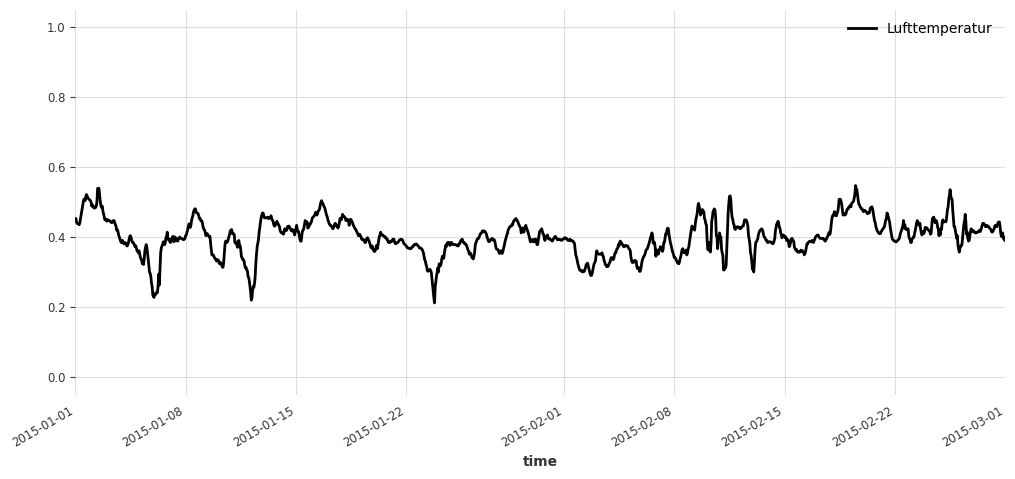

In [28]:
temperature_df = load_smhi('smhi-temperature-bma.csv')
temperature_df = temperature_df.resample('1H').asfreq()
temperature_df.ffill(inplace=True)

temperature_series = TimeSeries.from_dataframe(temperature_df)
temperature_series = temperature_series.drop_after(pd.Timestamp(f'{end_year + 1}-01-01'))
temperature_series = Scaler().fit_transform(temperature_series)

plt.figure(figsize=(12, 5))
temperature_series.plot()
plt.xlim(left=temperature_series.start_time(), right=temperature_series.start_time() + pd.DateOffset(months=2))

(16436.0, 16495.0)

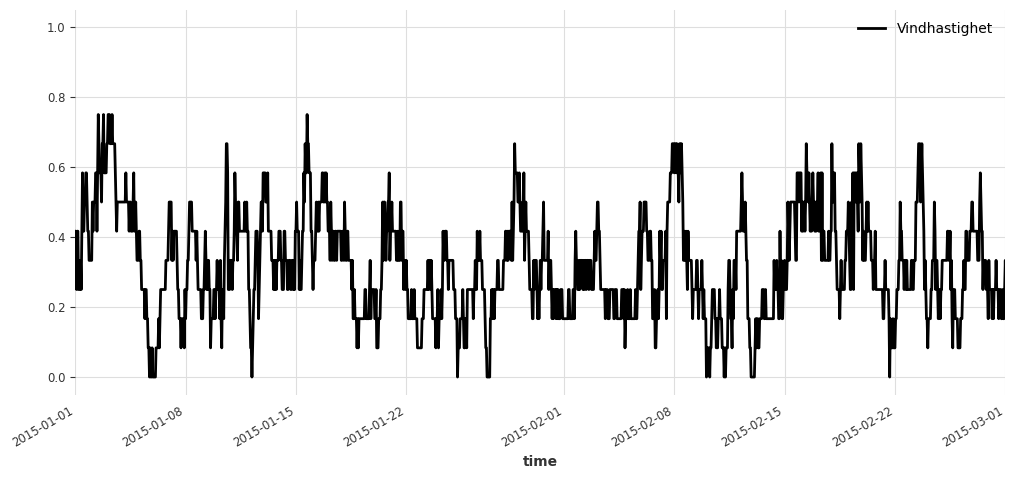

In [29]:
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1'])
windspeed_df = windspeed_df.resample('1H').asfreq()
windspeed_df.ffill(inplace=True)

windspeed_series = TimeSeries.from_dataframe(windspeed_df)
windspeed_series = windspeed_series.drop_after(pd.Timestamp(f'{end_year + 1}-01-01'))
windspeed_series = Scaler().fit_transform(windspeed_series)

plt.figure(figsize=(12, 5))
windspeed_series.plot()
plt.xlim(left=windspeed_series.start_time(), right=windspeed_series.start_time() + pd.DateOffset(months=2))

In [30]:
weather_series = solar_series.stack(temperature_series).stack(windspeed_series)
covariates = predicted_load_series.stack(datetime_series).stack(weather_series)

# Model Creation

In [39]:
from darts.models import BlockRNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    mode='min',
)

lstm_model = BlockRNNModel(
  model='LSTM',
  n_epochs=100,

  n_rnn_layers=2,
  hidden_dim=64,
  input_chunk_length=48,
  output_chunk_length=24,

  dropout=0.15,
  batch_size=128,
  pl_trainer_kwargs={ 'callbacks': [early_stop] },

  optimizer_kwargs={ 'lr': 1e-3 },
  save_checkpoints=True,
  log_tensorboard=True,
  model_name='LSTM_DayAheadPrices',

  force_reset=True,
  random_state=42
)

lstm_model.fit(
  train_transformed,
  past_covariates=covariates,
  val_series=val_transformed,
  val_past_covariates=covariates,
  verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 52.2 K
4 | fc            | Sequential       | 1.6 K 
---------------------------------------------------
53.8 K    Trainable params
0         Non-trainable params
53.8 K    Total params
0.215     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.15, n_epochs=100, input_chunk_length=48, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7d9bb4c53580>]}, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, model_name=LSTM_DayAheadPrices, force_reset=True, random_state=42)

# Evaluation
Testing the last iteration

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

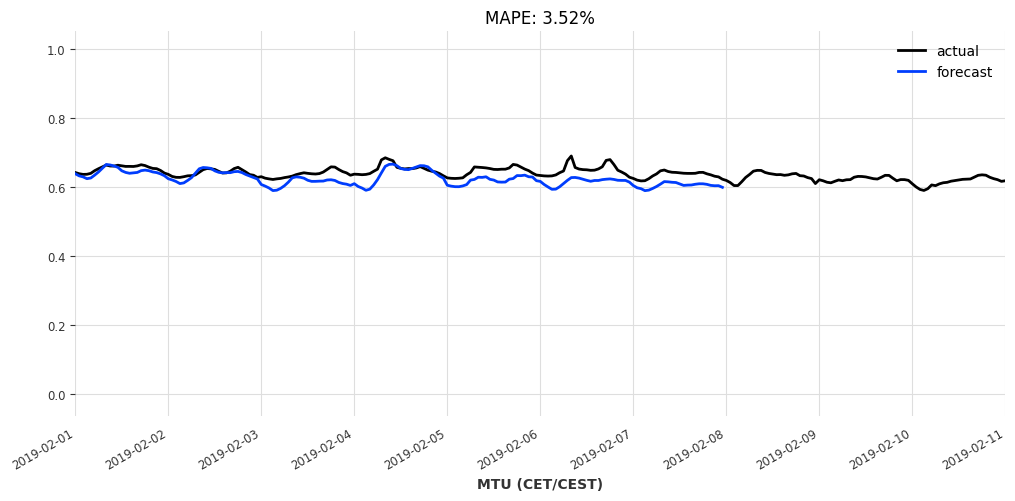

In [40]:
from darts.metrics import mape

def eval_model(model):
  pred_series = model.predict(n=168, past_covariates=covariates)
  plt.figure(figsize=(12, 5))
  series_transformed.plot(label="actual")
  pred_series.plot(label="forecast")
  plt.xlim(
    left=pd.Timestamp(cutoff),
    right=pd.Timestamp(cutoff) + pd.DateOffset(days=10)
  )
  plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
  plt.legend()

eval_model(lstm_model)

Comparison against the best model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

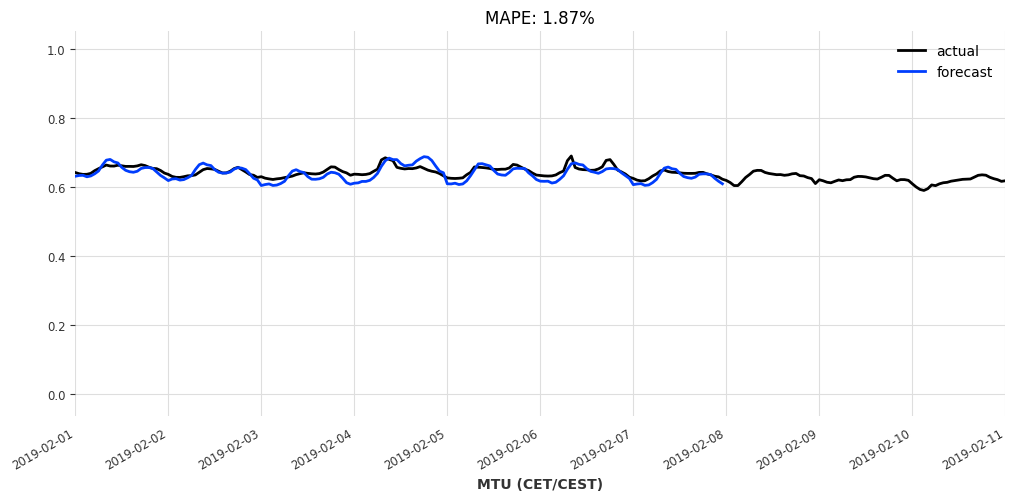

In [41]:
best_model = BlockRNNModel.load_from_checkpoint(model_name="LSTM_DayAheadPrices", best=True)
eval_model(best_model)